In [13]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pylab as pl
from IPython import display
from parameters import *
from micro import *
from aero_init import *
from parcel import *
from condensation import *
from collision import *
from analysis import *
from print_plot import *
from animation import *
from user_parameters import *
from timestep_routine import *

import itertools
import matplotlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intialization
## Input parameter

In [22]:
# model steering parameters
dt_widget, nt_widget, Condensation_widget, Collision_widget, n_particles_widget, n_particles_slider, collision_start_t_widget, max_z_widget = model_steering_input()
# section for widgets for parcel info
T_widget, P_widget, RH_widget, w_widget = parcel_info_input()

'Model steering parameters'

BoundedFloatText(value=0.5, description='dt [s]:', max=5.0, min=0.0001)

IntText(value=3600, description='nt:')

Checkbox(value=True, description='Condensation:')

Checkbox(value=False, description='Collision:')

BoundedIntText(value=500, description='n_particles:', max=1000, min=500)

IntSlider(value=500, description=' ', max=1000, min=500)

BoundedIntText(value=0, description='collision start time [s]:', max=10000)

BoundedFloatText(value=1400.0, description='z_max [m]:', max=1400.0, step=0.1)

'Parcel initial parameters: '

BoundedFloatText(value=293.2, description='T [K]:', max=320.0, min=200.0, step=0.1)

BoundedFloatText(value=101300.0, description='P [Pa]:', max=105000.0, min=95000.0, step=1.0)

BoundedFloatText(value=0.88, description='RH [-]:', max=0.99, min=0.01, step=0.01)

BoundedFloatText(value=0.5, description='w [m/s]:', max=10.0, step=0.1)

In [23]:
# user can choice the ascending mode
ascending_mode_widget = ascending_mode_input()
# choose the mode for aerosol initialization
mode_aero_init_widget = aero_mode_input()

'ascending mode: '

ToggleButtons(description='ascending', layout=Layout(width='max-content'), options=('linear', 'sine', 'in_clou…

'Aerosol initialisation: '

ToggleButtons(description='mode of aerosol init.:', layout=Layout(width='max-content'), options=('weighting_fa…

In [24]:
# Initialization parameters for aerosol (up to 4 modes)
gridwidget = grid_modes_input()

Please insert the parameters for each mode (=column). If you only want e.g. 3 modes, leave the last column empty
Click on the heading buttons to plot the distributions of the respective modes. (Plot functionality will be added later)
N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu


GridspecLayout(children=(Button(button_style='info', description='Mode #1 (plot)', layout=Layout(grid_area='wi…

# Time step routine

In [25]:
# setting of display mode while running: either output of variables in text form (fast, recommended) = 'text'
# or: continuously updated plot using plotly (slow, time & memory consuming) = 'graphics'
mode_displaytype_widget = timestep_display_mode_settings()

ToggleButtons(description='display mode:', layout=Layout(width='max-content'), options=('text_fast', 'graphics…

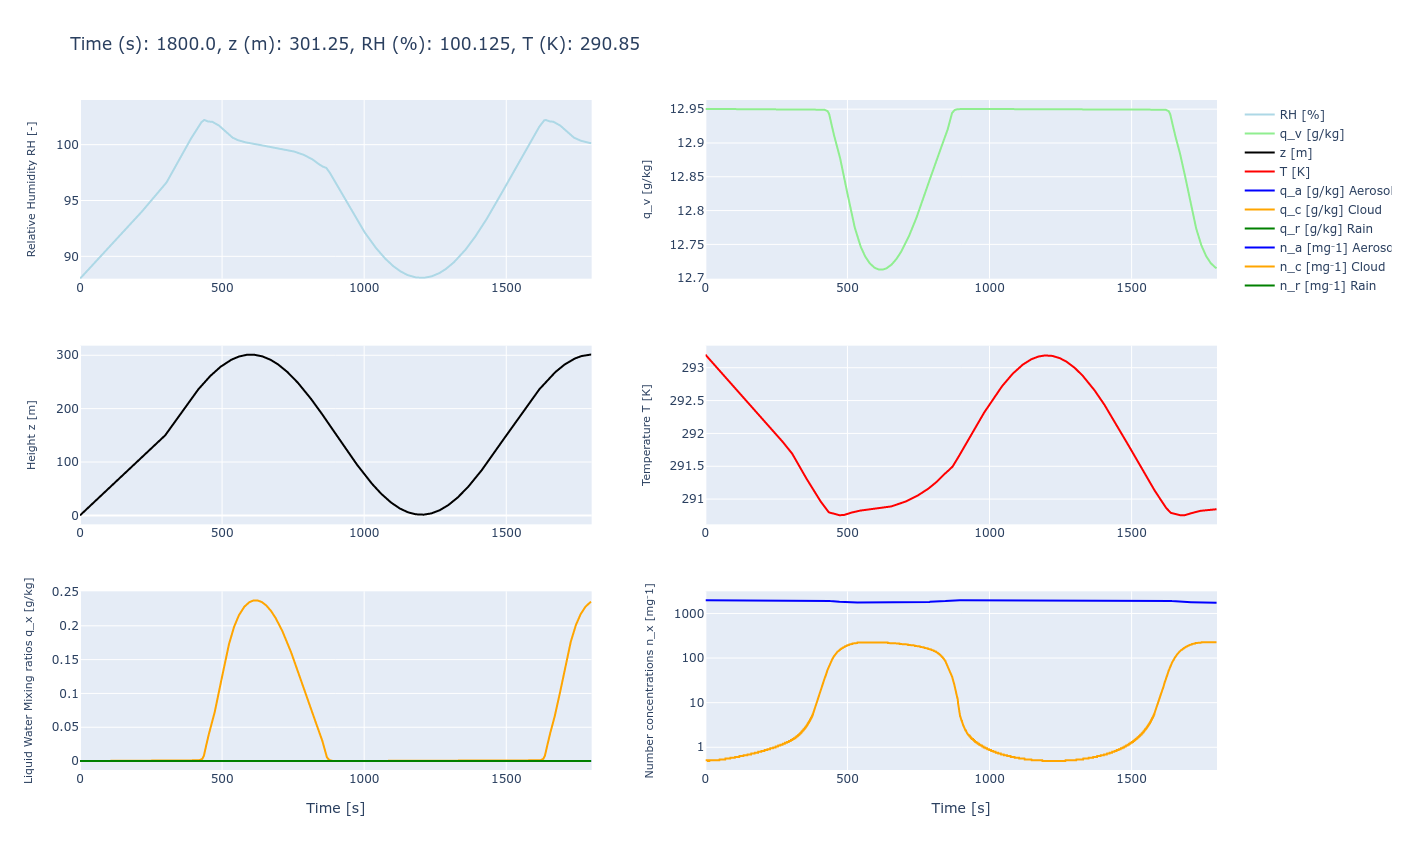

In [39]:
# initialization of the model (in aero_init module)
mode_aero_init, n_particles, P_parcel, T_parcel, q_parcel, z_parcel, w_parcel, \
N_aero, mu_aero, sigma_aero, nt, dt, max_z, do_condensation, \
do_collision, collision_start_time = model_init(dt_widget, nt_widget, Condensation_widget, Collision_widget, \
                                                collision_start_t_widget, n_particles_widget, T_widget, P_widget, RH_widget, \
                                                w_widget, max_z_widget, mode_aero_init_widget, gridwidget)

# time step routine (in model timestep_routine)
# performs the time-dependent model run
# computes output as text or graphics
time_array, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
qa_ts,qc_ts,qr_ts, na_ts,nc_ts,nr_ts, spectra_arr = timesteps_function(mode_aero_init, n_particles, P_parcel, T_parcel,q_parcel, z_parcel, w_parcel, N_aero, mu_aero,\
                                                                       sigma_aero, rho_aero, molecular_weight_aero, nt, dt, rm_spec, \
                                                                       ascending_mode_widget, mode_displaytype_widget, max_z, \
                                                                       do_condensation, do_collision, collision_start_time)

# post processing and analysis
## plots
plots can be drawn either as time-series or as vertical profiles

In [40]:
# user can choice if he wants the plots time-dependent or height-dependent (except of DSD and particle densities always being time dependent)
mode_plots_widget = plot_widgets_settings()

ToggleButtons(description='plots are:', layout=Layout(width='max-content'), options=('time-series', 'vertical …

/project/meteo/work/Julian.HumerHager/Hiwi_Clouds/PyLCM_parcel/print_plot.py:23: UserWarning:

Log scale: values of z <= 0 have been masked



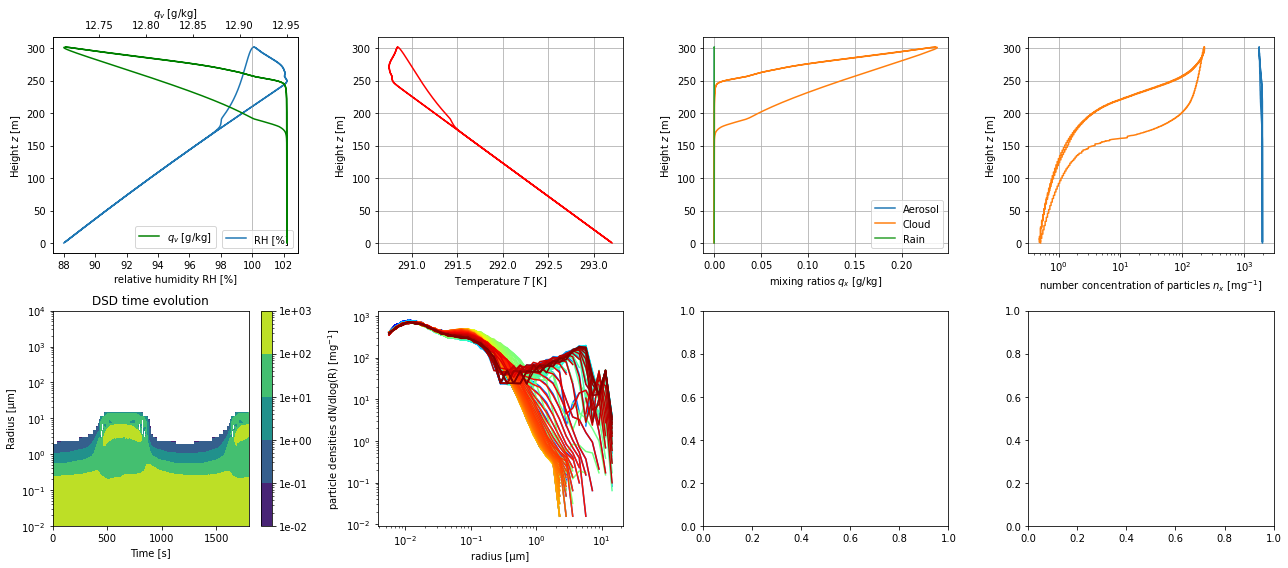

In [42]:
plot_mode=mode_plots_widget.value
subplot_array_function(plot_mode, dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, spectra_arr)

## data output
options for saving output variables and drop size spectra, files will be written in the subfolder 'output'

In [61]:
# save array of output variables into csv-file, optional filename can be given as filename='my_filename.csv'
save_model_output_variables(time_array, RH_parcel_array, q_parcel_array, T_parcel_array, z_parcel_array, qa_ts, \
                            qc_ts, qr_ts, na_ts, nc_ts, nr_ts, filename='testoutput_model_230809.csv')

Output data written to: output/testoutput_model_230809.csv


In [13]:
# save array of DSD spectra per timesteps, combined with radii to csv-file
save_model_output_dsd(spectra_arr, rm_spec, rl_spec, rr_spec, nt, filename='dsd_array_output_test_230822.csv')

Output data of droplet size distribution written to: output/dsd_array_output_test_230822.csv
